## Two Site 1D Hubbard QITE
This notebook is a guide to implement QITE on the Fermi-Hubbard model with two sites

We define a measurement function **measure** and a propagation function **propagate**

In **measure** we define circuits to measure the expectation value of any Pauli string

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are a[timestep][gate]. The indices of gate are as follows: 
<br>
<br>
1 stores a[x]: $e^{-ia[x]\Delta\tau\hat{X}}$
<br>
2 stores a[y]: $e^{-ia[y]\Delta\tau\hat{Y}}$
<br>
3 stores a[z]: $e^{-ia[z]\Delta\tau\hat{Z}}$
<br>
<br>
The 0 index stores the coefficient for the identity matrix $\hat{I}$, which is a global phase that we can ignore.

In [1]:
pauli_indices = [0,1,2,3]
pauli_pairs = [[i,j] for i in pauli_indices for j in pauli_indices]
print(pauli_pairs)

[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3]]


In [2]:
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs,correct_bitstring_probs
from pyquil import Program,get_qc

def measure(p,ro,idx,qc,qbits,correction_matrix):
    # Circuit to measure the expectation value of any Pauli string
    # initialize qc    
    qc = get_qc(qc)
    
    # measure II
    if idx == [0,0]:
        return 1
    # measure IX
    elif idx == [0,1]:
        p += H(qbits[0])
        p += SWAP(qbits[0],qbits[1])
    # measure IY
    elif idx == [0,2]:
        p += RX(np.pi/2,qbits[0])
        p += SWAP(qbits[0],qbits[1])
    # measure IZ
    elif idx == [0,3]:
        p += SWAP(qbits[0],qbits[1])

    # measure XI
    elif idx == [1,0]:
        p += H(qbits[0])
    # measure XX
    elif idx == [1,1]:
        p += H(qbits[0])
        p += H(qbits[1])
        p += CNOT(qbits[1],qbits[0])
    # measure XY
    elif idx == [1,2]:
        p += H(qbits[0])
        p += RX(np.pi/2,qbits[1])
        p += CNOT(qbits[1],qbits[0])
    # measure XZ
    elif idx == [1,3]:
        p += H(qbits[0])
        p += CNOT(qbits[1],qbits[0])
    # measure YI
    elif idx == [2,0]:
        p += RX(np.pi/2,qbits[0])
    # measure YX
    elif idx == [2,1]:
        p += RX(np.pi/2,qbits[0])
        p += H(qbits[1])
        p += CNOT(qbits[1],qbits[0])
    # measure YY
    elif idx == [2,2]:
        p += RX(np.pi/2,qbits[0])
        p += RX(np.pi/2,qbits[1])
        p += CNOT(qbits[1],qbits[0])
    #measure YZ
    elif idx == [2,3]:
        p += RX(np.pi/2,qbits[0])
        p += CNOT(qbits[1],qbits[0])
    # measure ZI
    elif idx == [3,0]:
        return 1
    # measure ZX
    elif idx == [3,1]:
        p += H(qbits[1])
        p += CNOT(qbits[1],qbits[0])
    # measure ZY
    elif idx == [3,2]:
        p += RX(np.pi/2,qbits[1])
        p += CNOT(qbits[1],qbits[0])
    # measure ZZ
    elif idx == [3,3]:
        p += CNOT(qbits[1], qbits[0])

    p += MEASURE(qbits[0],ro[0])
    
    exe = qc.compile(p)
    res = qc.run(exe)
    probs = estimate_bitstring_probs(res)
    # probs = correct_bitstring_probs(probs,[correction_matrix])
    return probs[0] - probs[1]

def propagate(p,alist,qbits):
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
            for gate in range(1,4):
                angle = np.real(alist[t][gate])
                if gate == 1:
                    p += RX(angle,qbits[0])
                elif gate == 2:
                    p += RY(angle,qbits[0])
                elif gate == 3:
                    p += RZ(angle,qbits[0])
                else:
                    raise ValueError

We now want to obtain the coefficients a[m] at the current time step and append to alist. For the 1-qubit case, we need to construct the matrix $S_{ij} = \langle \psi | \sigma_{i} \sigma_{j} | \psi \rangle$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\langle \psi | \sigma | \psi \rangle$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. These are stored in the matrices **idx** and **coeff** below.


In [3]:
import numpy as np

# To keep track of Lie algebra. Let P represent some Pauli operator. We want to know PiPj = cijPij.

idx = np.zeros([4,4],dtype=int)
idx[0,0] = 0
idx[0,1] = 1
idx[0,2] = 2
idx[0,3] = 3
idx[1,0] = 1
idx[1,1] = 0
idx[1,2] = 3
idx[1,3] = 2
idx[2,0] = 2
idx[2,1] = 3
idx[2,2] = 0
idx[2,3] = 1
idx[3,0] = 3
idx[3,1] = 2
idx[3,2] = 1
idx[3,3] = 0

coeff = np.zeros([4,4],dtype=complex)
coeff[0,0] = 1
coeff[0,1] = 1
coeff[0,2] = 1
coeff[0,3] = 1
coeff[1,0] = 1
coeff[1,1] = 1
coeff[1,2] = 1j
coeff[1,3] = -1j
coeff[2,0] = 1
coeff[2,1] = -1j
coeff[2,2] = 1
coeff[2,3] = 1j
coeff[3,0] = 1
coeff[3,1] = 1j
coeff[3,2] = -1j
coeff[3,3] = 1

print(idx)
print(coeff)

[[0 1 2 3]
 [1 0 3 2]
 [2 3 0 1]
 [3 2 1 0]]
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0.+1.j -0.-1.j]
 [ 1.+0.j -0.-1.j  1.+0.j  0.+1.j]
 [ 1.+0.j  0.+1.j -0.-1.j  1.+0.j]]


For the 2-qubit case, we can reuse these matrices. We need to calculate $S_{ij} = \langle \psi | Q_{i} Q_{j} | \psi \rangle = \langle \psi | ( \sigma_{i0} \otimes \sigma_{i1} ) ( \sigma_{j0} \otimes \sigma_{j1} ) | \psi \rangle = \langle \psi | \left( \sigma_{i0} \sigma_{j0} \otimes \sigma_{i1} \sigma_{j1} \right) | \psi \rangle$ and the vector $b_{i} = i \langle \psi | Q_{i} | \Delta_{0} \rangle - h.c. = i \langle \psi | {( \sigma_{i0} \otimes \sigma_{i1})} | \Delta_{0} \rangle - h.c.$ where $| \Delta_{0} \rangle = \frac{(| \psi' \rangle - | \psi \rangle)}{\Delta \tau}$

Using this, we can construct the S matrix and b vector. We use the **idx** and **coeff** matrices and the function np.linalg.std to solve for x in **update_alist**. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist.

In [4]:
# hm_list = [[[[1, 0], [-1]], [[0, 1], [-1]]], [[[0, 0], [1.0]], [[3, 3], [1.0]]]]
# hm = hm_list[0]
# hm

In [5]:
# a matrix should be 16 x 16
def update_alist(sigma_expectation,alist,db,delta,hm):
    # Obtain A[m]

    # Step 1: Obtain S matrix
    S = np.zeros([16,16],dtype=complex)
    for i in range(16):
        for j in range(16):
            pp_i = pauli_pairs[i]
            pp_j = pauli_pairs[j]
            # This becomes pp_i[0] pp_j[0] \otimes pp_i[1] ppi_j[1]
            # pauli_pair = [[pp_i[0], pp_j[0]], [pp_i[1], pp_j[1]]
            # p_q0, p_q1 = [[pp_i[0], pp_j[0]], [pp_i[1], pp_j[1]]
            # p_q0, p_q1 = [idx[p0[0],p0[1]], idx[p1[0],p1[1]]]
            idx_q0, idx_q1 = [idx[pp_i[0],pp_j[0]], idx[pp_i[1],pp_j[1]]]
            coeff_q0, coeff_q1 = [coeff[pp_i[0],pp_j[0]], coeff[pp_i[1],pp_j[1]]]
            # this is probably wrong
            coeff_val = coeff_q0 / coeff_q1
            S[i,j] = sigma_expectation[idx_q0,idx_q1]*coeff_val
            # TODO: relative phase!!!
            # p_i has phase coeff[pp_i[0],pp_j[0]]
            # p_j has phase coeff[pp_i[1],pp_j[1]]

    # should be length 16
    # Step 2: Obtain b vector
    b = np.zeros([16],dtype=complex)
    # c is the squared norm
    c = 1
    for i in range(len(hm)): #TODO
        # each local Hamiltonian term hm can be a sum of 2-qubit operators...
        # ... see the construction of the hm_list to see why... for each term in hm (hm[i]):
        # hm[i][1][0] is the multiplicative constant in the Hamiltonian
        # hm[i][0][0] is the index of the Pauli matrix for qubit 0
        # hm[i][0][1] is the index of the Pauli matrix for qubit 1
        c -= 2*db*hm[i][1][0]*sigma_expectation[hm[i][0][0], hm[i][0][1]]
    # c is now the norm, after we take its square root
    c = np.sqrt(c)
    # iterate through b list:
    for i in range(16):
        idx_q0, idx_q1 = pauli_pairs[i]
        b[i] += (sigma_expectation[idx_q0, idx_q1]/c-sigma_expectation[idx_q0, idx_q1])/(db)
        for j in range(len(hm)):
            idx_q0, idx_q1 = [idx[idx_q0,hm[j][0][0]], idx[idx_q1,hm[j][0][1]]]
            # TODO: relative phase!!!
            coeff_q0, coeff_q1 = [coeff[idx_q0,hm[j][0][0]], coeff[idx_q1,hm[j][0][1]]]
            coeff_val = coeff_q0 / coeff_q1
            b[i] -= hm[j][1][0]*coeff_val*sigma_expectation[idx_q0,idx_q1]/c
        b[i] = 1j*b[i] - 1j*np.conj(b[i])

    # Step 3: Add regularizer
    dalpha = np.eye(16)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S+np.transpose(S)+dalpha,-b,rcond=-1)[0]
    alist.append([])
    for i in range(len(x)):
        alist[-1].append(-x[i]*2*db)
    return c

def estimate_assignment_probs(q, shots, qc_name,p00=None,p11=None):
    """
    Estimate the readout assignment probabilities for a given qubit ``q``.
    The returned matrix is of the form::
            [[p00 p01]
             [p10 p11]]
    :param int q: The index of the qubit.
    :param int trials: The number of samples for each state preparation.
    :param qc: The quantum computer we wish to sample.
    :return: The assignment probability matrix
    :rtype: np.array
    """
    qc = get_qc(qc_name)
    if p00 is None:
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        p += I(q)
        p += MEASURE(q,ro[0])
        exe = qc.compile(p)
        results_i = np.sum(qc.run(exe))

        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        p += X(q)
        p += MEASURE(q,ro[0])
        exe = qc.compile(p)
        results_x = np.sum(qc.run(exe))
    else:
        p = Program()
        p.define_noisy_readout(q,p00=p00,p11=p11)
        ro = p.declare('ro','BIT',1)
        p += I(q)
        p += MEASURE(q,ro[0])
        cxn = QVMConnection()
        results_i = np.sum(cxn.run(p,[0],trials=shots))

        p = Program()
        p.define_noisy_readout(q,p00=p00,p11=p11)
        ro = p.declare('ro','BIT',1)
        p += X(q)
        p += MEASURE(q,ro[0])
        cxn = QVMConnection()
        results_x = np.sum(cxn.run(p,[0],trials=shots))


    p00 = 1. - results_i / float(shots)
    p11 = results_x / float(shots)
    return np.array([[p00, 1 - p11], [1 - p00, p11]])

Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [6]:
import matplotlib.pyplot as plt
# from pyquil.gates import *
# from pyquil.noise import estimate_bitstring_probs
# from pyquil import Program,get_qc

def ansatz(p,qbits):
    None

def measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
            p = Program()
            p.wrap_in_numshots_loop(shots)
            # declare readout register with 1 bit
            ro = p.declare('ro','BIT',1)
            ansatz(p,qbits)
            propagate(p,alist,qbits)
            pauli_pair = [hm[j][0][0],hm[j][0][1]]
            Energy += hm[j][1][0]*measure(p,ro,pauli_pair,qc,qbits,correction_matrix)
    return Energy

def get_expectation(alist,shots,qc,qbits,correction_matrix):
    # Obtain the expectation values of the Pauli string at each time step
    sigma_expectation = np.zeros([4,4],dtype=complex)
    for i in range(16):
        idx_q0, idx_q1 = pauli_pairs[i]
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        ansatz(p,qbits)
        propagate(p,alist,qbits)
        sigma_expectation[idx_q0,idx_q1] = measure(p,ro,pauli_pairs[i],qc,qbits,correction_matrix)
    return sigma_expectation

def qite_step(alist,shots,qc,qbits,correction_matrix,db,delta,hm_list):
    for j in range(len(hm_list)):
        sigma_expectation = get_expectation(alist,shots,qc,qbits,correction_matrix)
        norm = update_alist(sigma_expectation,alist,db,delta,hm_list[j])
    return alist

def qite(qc,qbits,shots,db,delta,N,hm_list):
    E = np.zeros([N+1],dtype=complex)
    alist = []

    # Readout error mitigation, estimate p(0|0),p(0|1),p(1|0),p(1|1)
    # TODO: will eventually need to extend correction matrix to two qubit case, but ignore for now
    correction_matrix = estimate_assignment_probs(qbits[0],20000,qc)
    E[0] = measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix)
    print("Initial energy: ", E[0])
    # Qite main loop
    for i in range(1,N+1):
        correction_matrix = estimate_assignment_probs(qbits[0],20000,qc)
        alist = qite_step(alist,shots,qc,qbits,correction_matrix,db,delta,hm_list)
        E[i] = measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix)
#         print("a list: ", alist)
        print("energy: ", E[i])
    return E

### Running QITE with 2-site 1D Hubbard Hamiltonian
We run QITE with a two qubit QVM using the 2-site 1D Hubbard Hamiltonian:
$$H = -t \left( X \otimes I + I \otimes X \right) + \frac{U}{2} \left( I + Z \otimes Z \right)$$

In [7]:
# ---- input parameters for qite
N = 40
shots = 1000
db = 0.1
# use a 2-qubit qvm
qc = '2q-qvm'
qbits = [0, 1]
# kinetic energy contribution
t = 1
# potential energy contribution
U = 2
print("t = ", t, ", U = ", U)
# construct hm_list to represent H = -t(X \otimes I + I \otimes X) + U/2 (I + Z \otimes Z)
hm_list = []
# the first term (hopping kinetic term) of H
hm_list.append([])
# fix this by expanding the indices
hm_list[0].append([[1, 0],[-t]])
hm_list[0].append([[0, 1],[-t]])
# the second term (onsite potential term) of H
hm_list.append([])
hm_list[1].append([[0, 3],[U/2]])
hm_list[1].append([[3, 3],[U/2]])
print("hm list: ", hm_list)
delta = 0.1
print("running qite...")
E = qite(qc,qbits,shots,db,delta,N,hm_list)

t =  1 , U =  2
hm list:  [[[[1, 0], [-1]], [[0, 1], [-1]]], [[[0, 3], [1.0]], [[3, 3], [1.0]]]]
running qite...
Initial energy:  (0.946+0j)
energy:  (0.946+0j)
energy:  (0.062000000000000055+0j)
energy:  (-1.362+0j)
energy:  (-0.9720000000000002+0j)
energy:  (0.4599999999999999+0j)
energy:  (-0.5640000000000001+0j)
energy:  (0.07000000000000006+0j)
energy:  (-0.3420000000000001+0j)
energy:  (-0.694+0j)
energy:  (-0.018000000000000016+0j)
energy:  (-0.544+0j)
energy:  (0.24200000000000005+0j)
energy:  (-1.184+0j)
energy:  (1.1179999999999999+0j)
energy:  (0.99+0j)
energy:  (-0.268+0j)
energy:  (-0.258+0j)
energy:  (0.22200000000000014+0j)
energy:  (0.19999999999999996+0j)
energy:  (0.12200000000000005+0j)
energy:  (-0.026000000000000023+0j)
energy:  (-0.22199999999999998+0j)
energy:  (-1.2959999999999998+0j)
energy:  (-1.166+0j)
energy:  (-0.8180000000000001+0j)
energy:  (-0.38200000000000006+0j)
energy:  (-0.22999999999999998+0j)
energy:  (-0.9279999999999999+0j)
energy:  (-1.154+0j)


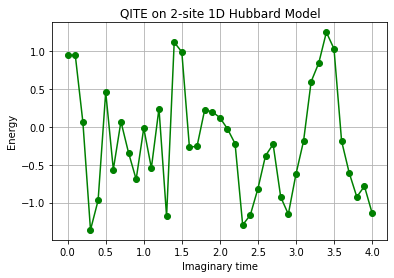

In [14]:
# some trouble with numpy sometimes because of imaginary part... so plot only real part of E
plt.plot(np.arange(0,N+1)*db,E.real,'g-o',label='QITE')
plt.title("QITE on 2-site 1D Hubbard Model")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.grid()
plt.show()